In [1]:
import os
import random
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats
from sklearn.preprocessing import StandardScaler
import itertools
from textblob import TextBlob
import scikit_posthocs as sp
import warnings
warnings.filterwarnings('ignore')

Path to directories where data is stored. Set home = 1 for WFH, 0 otherwise.

In [2]:
home = 0
if home:
    infiledir = r"C:\Users\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    rand_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis"
    
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    rand_dir = r"P:\EW_analysis\analysis"
    writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"

utils

In [ ]:
def scale_scores(in_df, col_names, scaler_type):
    """ 
    Scale questionnaire scores.

    Parameters
    ----------
    in_df:  pandas Dataframe
        Dataframe to operate on.
    col_names:  list
        list of column names to operate on.
    scaler_type:    scaler to use

    Returns
    -------
    Dataframe with scaled questionnaire scores.

    """
    scaler = scaler_type
    for col in col_names:
        in_df[col+'_scaled'] = scaler.fit_transform(in_df[col].values.reshape(-1,1))
    return in_df


# extract numbers from strings
def find_number(text):
    """ 
    Extract numbers from strings

    Parameters
    ----------
    text: str
        input string to operate on
    
    Returns
    -------
    Numerical input string content as string.

    """ 
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

def get_diaries(directory,filenames,colnames):
    """
    Extract written statements from diary files.

    Parameters
    ----------
    directory:   str
        path to input directory
    filenames:  list
        list of input filenames to operate on
    colnames:   str
        columns to read in from diary files
    """
    pnums = []
    writing = []
    days = []
    for i,name in enumerate(filenames):
        diary_df = pd.read_csv(os.path.join(directory,name),skiprows = [0,2],usecols = colnames)
        diary_df = diary_df.loc[diary_df.Progress==100,:]
        diary_df['day'] = i+1
        pnums.append(diary_df.iloc[:,1])
        writing.append(diary_df.iloc[:,2])
        days.append(diary_df.iloc[:,3])
    return pnums,days,writing

def set_initial_vals(in_df,col_list):
    """ 
    Set values for all assessment time points to session 1 value.

    Paramters
    ---------
    in_df:  pandas DataFrame
        dataframe to operate on
    col_list:   list
        list of columns to operate on

    Returns
    -------
    data frame with specified columns modified.
    
    """
    sub_ids = in_df.id.unique()
    for pnum in (sub_ids):
        for col in col_list:
            initial_val = in_df.loc[(in_df.id==pnum)&(in_df.order==1),col].iloc[0]
            in_df.loc[(in_df.id==pnum)&(in_df.order.isin([2,3,4])), col] = initial_val
    return in_df
    
def demographics_check(in_df, num_subs):
    """ 
    Basic demographics check.

    Parameters
    ----------
    in_df:  pandas DataFrame
        input dataframe to operate on
    num_subs:   int
        number of subjects
    
    Returns
    -------
        DataFrame of %age of sample in demographic categories.
    """
    demographics_df = in_df.filter(like = 'Selected Choice', axis = 1)
    sex = demographics_df.filter(like = 'your sex',axis = 1).value_counts()/num_subs
    ethnicity = demographics_df.filter(like = 'your ethnic group',axis = 1).value_counts()/num_subs
    education = demographics_df.filter(like = 'education',axis = 1).value_counts()/num_subs
    working = demographics_df.filter(like = 'working',axis = 1).value_counts()/num_subs

    op_df = pd.DataFrame({'sex': sex, 'ethnicity':ethnicity,'education':education,'working':working})
    return (op_df)*100
    
class Data_Explorer:
    def __init__(self, response_var):
        self.response_name = response_var
    
    def nan_ids(self,in_df):
        self.response_vals = in_df[self.response_name]
        self.nan_ids = in_df.loc[in_df[self.response_name].isna(),'id'].values
    
    def zero_ids(self, in_df):
        self.zero_ids = in_df.loc[(in_df[self.response_name]==0)&(in_df.order.isin([2,3,4])), 'id'].unique()
        self.zero_groups = in_df.loc[in_df.id.isin(self.zero_ids),'Group'].value_counts()
    
    def visualize_dist(self, distribution = None):
        if not distribution:
            self.distribution = 'normal'
        else:
            self.distribution = distribution


        if self.distribution == 'normal':
            fig = sm.qqplot(self.response_vals,line = 'q')
            fig.show()
        else:
            fig = sm.qqplot(self.response_vals,dist = stats.gamma,distargs = (4,),line = 'q')
            fig.show()
    
    def draw_kdeplot(self,in_df,names,colors):
        for i,session in enumerate(in_df.order.unique()):
            sns.kdeplot(all_dat_df.loc[in_df.order == session, self.response_name],color = colors[i] )
        plt.legend(names)
    
    def draw_mean_trajectories(self,in_df):
        fig, ax = plt.subplots(figsize=(6, 6))
        fig = interaction_plot(
        x=in_df.time,
        trace=in_df.Group,
        response=in_df[self.response_name],
        colors=["red", "blue","black"],
        markers=["D", "^",'x'],
        ms=10,
        ax=ax,
        )
               
def get_qic_table(data_df, formula, group, family_name):
    model_covi = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Independence(), family = family_name,missing = 'drop').fit()
    model_covx = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Exchangeable(), family = family_name,missing = 'drop').fit()
    model_covar = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Autoregressive(), family = family_name,missing = 'drop').fit()
    out_df = pd.DataFrame({'dependency type': ['Independence','Exchangeable','Autoregressive'], 'QIC': [model_covi.qic()[0], model_covx.qic()[0],model_covar.qic()[0]], 'QICu': [model_covi.qic()[1], model_covx.qic()[1],model_covar.qic()[1]]})
    return out_df

# simulate some data for the prediction (mean +/- 1 std)
def simulate_to_predict(dat_vals):
    dat_sim = []
    mu = dat_vals.mean()
    std = dat_vals.std()
    for i in range(0,len(dat_vals)):
        value = random.gauss(mu,std)
        if value>mu+std:
            value == mu+std
        elif value<mu-std:
            value == mu-std
        dat_sim.append(value)
    return dat_sim

Load the qualtrics data and add columns for time in weeks and whether or not the same event was reported in the ADNM-20. The latter is done by checking the sequence matcher and spacy based scores against a pre-set threshold.

In [4]:
all_dat_df = pd.read_csv(os.path.join(infiledir, 'all_dat_df.csv')) # read in data
# column to denote whether or not they reported the same stressful events for the ADNM-20 at each time point
all_dat_df['same_event'] = 0
# if spacy version suggests >0.8 similarity, set to 1 (inspection showed that this seems to be a reasonable cut-off.)
all_dat_df.loc[all_dat_df.most_stressful_similarity2>0.8,'same_event'] = 1
all_dat_df.loc[(all_dat_df.most_stressful_similarity>0.2)&(all_dat_df.most_stressful_similarity2<0.8),'same_event'] = 1 # also set to 1 if spacy is below the cut-off, but SequenceMatcher is higher than 0.2 (based on visual inspection)
all_dat_df.loc[(all_dat_df.order==1),'same_event']=np.nan

all_dat_df['time'] = all_dat_df.order
all_dat_df.loc[all_dat_df.order==1,'time'] = 0
all_dat_df.loc[all_dat_df.order==2,'time'] = 2
all_dat_df.loc[all_dat_df.order==3,'time'] = 4
all_dat_df.loc[all_dat_df.order==4,'time'] = 12


In [6]:
# set ERQ and RRS values to session 1 vals.
all_dat_df = set_initial_vals(all_dat_df, ['ERQ_reapp','ERQ_sup','RRS_total'])
# check demographics.
num_subs = len(all_dat_df.id.unique())
demographics_sum = demographics_check(all_dat_df, num_subs)

We've now got to find participant ages. These are in the screening data file, which does not have participant numbers, only screening ids. We therefore have to match the screening ids to the participant numbers via the randomisation file.

In [29]:
screening_df = pd.read_csv(os.path.join(rand_dir, 'screening_data.csv'),skiprows = [0,2],usecols = ['Please enter the last four digits of your phone number','Please enter your age.'])
rand_df = pd.read_csv(os.path.join(rand_dir,'randomisation.csv'))
rand_df.loc[:,'Screening Id'] = rand_df['Screening Id'].apply(find_number).astype('int')
screening_df = screening_df.loc[screening_df['Please enter the last four digits of your phone number'].isin(rand_df['Screening Id']),:]
screening_df['id'] = rand_df.loc[rand_df['Screening Id'].isin(screening_df['Please enter the last four digits of your phone number']),'Participant number'].apply(find_number).astype('int')
print("The mean age was", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].mean())
print("Std was", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].std())
print("The range was: ", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].min(), screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].max())

The mean age was 28.104166666666668
Std was 4.727644293659992
The range was:  20.0 37.0


We'll do some basic checks on the writing to get an idea of whether participants adhered to the instructions.

In [36]:
# read in files from directory
writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"
writing_files = os.listdir(writing_dir)
ew_files = [f for f in writing_files if 'T1' in f]
ewre_files = [f for f in writing_files if 'T2' in f]
ctr_files = [f for f in writing_files if 'T3' in f]
print(ew_files)
print(ewre_files)
print(ctr_files)

ids,days,writing = get_diaries(writing_dir,ew_files,[4,18,23])
ew_frame = pd.DataFrame({'id':pd.Series(list(itertools.chain.from_iterable(ids))),'writing': pd.Series(list(itertools.chain.from_iterable(writing))),'days':pd.Series(list(itertools.chain.from_iterable(days)))})
ids,days,writing = get_diaries(writing_dir,ewre_files,[4,18,23])
ewre_frame = pd.DataFrame({'id':pd.Series(list(itertools.chain.from_iterable(ids))),'writing': pd.Series(list(itertools.chain.from_iterable(writing))),'days':pd.Series(list(itertools.chain.from_iterable(days)))})
ids,days,writing = get_diaries(writing_dir,ctr_files,[4,18,23])
ctr_frame = pd.DataFrame({'id':pd.Series(list(itertools.chain.from_iterable(ids))),'writing': pd.Series(list(itertools.chain.from_iterable(writing))),'days':pd.Series(list(itertools.chain.from_iterable(days)))})

# now let's check word counts for each condition.
ew_frame['word_count'] = ew_frame.writing.astype('str').str.split().apply(len)
ewre_frame['word_count'] = ewre_frame.writing.astype('str').str.split().apply(len)
ctr_frame['word_count'] = ctr_frame.writing.astype('str').str.split().apply(len)

# now to get the word count for each day and condition
print("EW:", ew_frame.groupby('days').word_count.mean())
print("EWRE:", ewre_frame.groupby('days').word_count.mean())
print("CTR:", ctr_frame.groupby('days').word_count.mean())

stat, pval = stats.f_oneway(ew_frame.groupby('days').word_count.mean(),ewre_frame.groupby('days').word_count.mean(),ctr_frame.groupby('days').word_count.mean())
print('Word count different between groups when ordered by day - F: {}, p: {}'.format(stat,pval))
stat, pval = stats.f_oneway(ew_frame.word_count,ewre_frame.word_count,ctr_frame.word_count) # check if word count is significantly different between the different conditions
print('Word count different between groups - F: {}, pval {}'.format(stat,pval))

['Writing_T1_Day1.csv', 'Writing_T1_Day2.csv', 'Writing_T1_Day3.csv', 'Writing_T1_Day4.csv']
['Writing_T2_Day1.csv', 'Writing_T2_Day2.csv', 'Writing_T2_Day3.csv', 'Writing_T2_Day4.csv']
['Writing_T3_Day1.csv', 'Writing_T3_Day2.csv', 'Writing_T3_Day3.csv', 'Writing_T3_Day4.csv']
EW: days
1    568.536585
2    510.450000
3    488.641026
4    470.076923
Name: word_count, dtype: float64
EWRE: days
1    613.902439
2    575.463415
3    508.675000
4    491.900000
Name: word_count, dtype: float64
CTR: days
1    551.300
2    443.750
3    372.500
4    423.675
Name: word_count, dtype: float64
Word count different between groups when ordered by day - F: 2.824778438614454, p: 0.11165575056748316
Word count different between groups - F: 6.274732005861162, pval 0.002042098890525962


We'll use TextBlob to get some basic subjectivity and polarity scores for each group.

In [37]:
ew_frame['Group'] = 'EW'
ewre_frame['Group'] = 'EWRE'
ctr_frame['Group'] = 'CTR'
writing_df = pd.concat([ew_frame,ewre_frame,ctr_frame]).reset_index()
writing_df['sentiment'] = writing_df.writing.astype('str').apply([lambda x: TextBlob(x)])
writing_df['polarity'] = writing_df.sentiment.apply([lambda x: x.sentiment.polarity])
writing_df['subjectivity'] = writing_df.sentiment.apply([lambda x: x.sentiment.subjectivity])

Data exploration

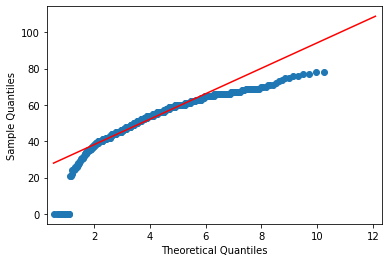

In [111]:
dt = Data_Explorer('ADNM_burden_total')
dt.nan_ids(all_dat_df)
dt.zero_ids(all_dat_df)
dt.visualize_dist(distribution = 'gamma')


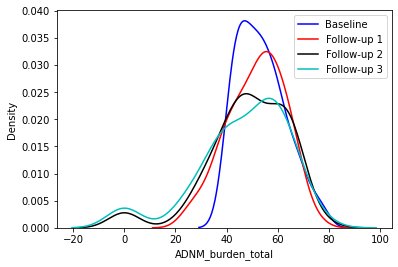

In [108]:
colors = ['b','r','k','c']
names = ['Baseline','Follow-up 1', 'Follow-up 2','Follow-up 3']
dt.draw_kdeplot(all_dat_df,names,colors)

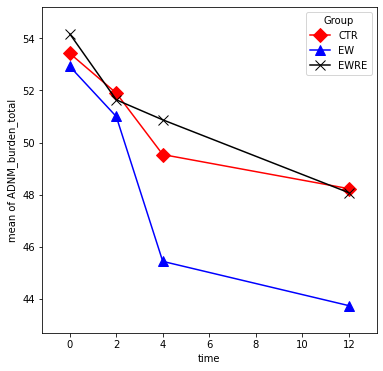

In [112]:
dt.draw_mean_trajectories(all_dat_df)

In [120]:
all_dat_df = scale_scores(all_dat_df,['ERQ_reapp','ERQ_sup','RRS_total','ADNM_burden_total'],StandardScaler())

In [317]:
# get simulated data & prepare a dataframe for the analysis below.
ERQ_sim = simulate_to_predict(all_dat_df.ERQ_reapp)
model_df = pd.DataFrame({'id':all_dat_df.id,'time':all_dat_df.time,'Group':all_dat_df.Group})
model_df['ERQ_reapp_scaled'] = StandardScaler().fit_transform(np.array(ERQ_sim).reshape(-1,1))
ERQ_sup_sim = simulate_to_predict(all_dat_df.ERQ_sup)
model_df['ERQ_sup_scaled'] = StandardScaler().fit_transform(np.array(ERQ_sup_sim).reshape(-1,1))
RRS_sim = simulate_to_predict(all_dat_df.RRS_total)
model_df['RRS_scaled'] = StandardScaler().fit_transform(np.array(RRS_sim).reshape(-1,1))

Model ADNM-20 scores.

In [124]:
# check whether scores are significantly different at baseline
data = [all_dat_df.loc[all_dat_df.Group == 'EW','ADNM_burden_total'].values,all_dat_df.loc[all_dat_df.Group == 'EWRE','ADNM_burden_total'].values,all_dat_df.loc[all_dat_df.Group == 'CTR','ADNM_burden_total'].values]
print(stats.kruskal(data[0],data[1],data[2]))
print(sp.posthoc_dunn(data, p_adjust = 'bonferroni'))

KruskalResult(statistic=nan, pvalue=nan)
          1        2         3
1  1.000000  0.67787  0.456512
2  0.677870  1.00000  1.000000
3  0.456512  1.00000  1.000000


In [318]:
# Model mean response structure using a Tweedie distribution, link is log, covariance structure is AR(1)
model_tweedie_adnm = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

In [319]:
# compare QIC/QICu between different covariance structures.
adnm_qic_df = get_qic_table(all_dat_df, "ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))","id",sm.families.Tweedie())
print(adnm_qic_df)

  dependency type          QIC        QICu
0    Independence  1735.964203  617.609802
1    Exchangeable  1725.798158  618.313632
2  Autoregressive  1776.135477  617.570451


In [320]:
model_tweedie_adnm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: GEE
==================================================================================================
Model:                           GEE                          AIC:                       nan      
Link Function:                   log                          BIC:                       -418.2020
Dependent Variable:              ADNM_burden_total            Log-Likelihood:            nan      
Date:                            2021-11-15 12:16             LL-Null:                   nan      
No. Observations:                466                          Deviance:                  2371.3   
Df Model:                        11                           Pearson chi2:              1.81e+03 
Df Residuals:                    454                          Scale:                     3.9949   
Method:                          IRLS                                                             
--------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z     P>|z|   [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                           3.9695   0.0322 123.3998 0.0000  3.9065 4.0326
C(time)[T.2.0]                                     -0.0370   0.0371  -0.9963 0.3191 -0.1097 0.0358
C(time)[T.4.0]                                     -0.0624   0.0454  -1.3735 0.1696 -0.1514 0.0266
C(time)[T.12.0]                                    -0.0918   0.0581  -1.5795 0.1142 -0.2058 0.0221
C(Group, Treatment('CTR'))[T.EW]                   -0.0027   0.0420  -0.0635 0.9494 -0.0850 0.0797
C(Group, Treatment('CTR'))[T.EWRE]                 -0.0069   0.0427  -0.1605 0.8725 -0.0906 0.0769
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]     0.0274   0.0520   0.5267 0.5984 -0.0745 0.1293
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]    -0.0874   0.0733  -1.1932 0.2328 -0.2311 0.0562
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]   -0.0944   0.0875  -1.0793 0.2805 -0.2658 0.0770
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]   0.0147   0.0509   0.2894 0.7723 -0.0851 0.1146
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]   0.0291   0.0566   0.5138 0.6074 -0.0819 0.1401
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE]  0.0080   0.0757   0.1056 0.9159 -0.1404 0.1564
==================================================================================================

"""

Some basic model checks

Plotting fitted against residuals. Note that residuals need not be normally distributed for GEEs. We are looking for two main things:
(i) Are there any obvious non-linearities?
(ii) Inspect the variance of the residuals with respect to the fitted values. Look for non-constant variance, which would require a change in the model.
Heree things look decent apart from the obvs outlier.

In [321]:
def model_checks(data_df, columns_to_use, y_to_use,GEE_res):
    gee_res_df = data_df.loc[:,columns_to_use]
    drop_inds = gee_res_df.loc[gee_res_df[y_to_use].isna(),:].index.values
    gee_res_df = gee_res_df.drop(labels = drop_inds, axis = 0)
    gee_res_df['resid_dev'] = GEE_res.resid_deviance
    gee_res_df['fitted'] = GEE_res.fittedvalues
    a = GEE_res.resid_deviance
    a.sort()
    fig = plt.figure()
    res = stats.probplot(a,dist = stats.halfnorm,sparams = (-0.18,10), plot=plt)
    plt.show()
    # plotting fitted agains residuals
    g = sns.lmplot(x = "fitted", y = "resid_dev", hue = "Group", data = gee_res_df)
    g = (g.set_axis_labels("Predicted score", "Deviance residuals"))#.set(xlim=(42, 55)))
    g = sns.lmplot(x = "time", y = "resid_dev", hue = "Group", data = gee_res_df)
    g = (g.set_axis_labels("Time [Weeks]", "Deviance residuals").set(xlim=(-1, 14)))

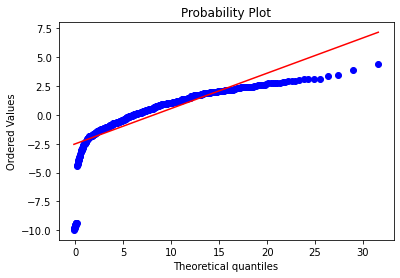

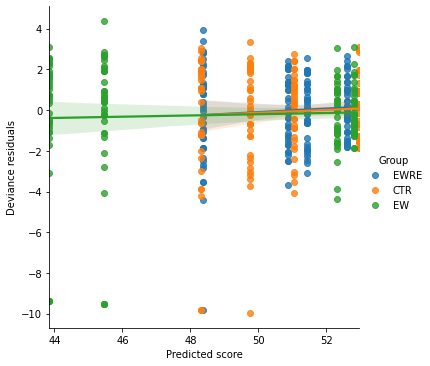

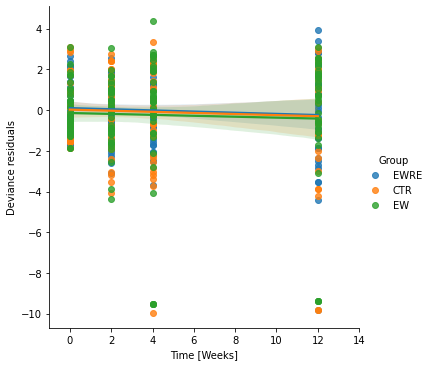

In [322]:
model_checks(all_dat_df,['ADNM_burden_total','id','time','Group'],'ADNM_burden_total',model_tweedie_adnm)

We have some outliers, both at the lower and upper extreme. Some of these are probably the zeros, but we also had some participant with extremely high scores. With the half normal plot, we're not looking for the residuals to be normally distributed, we're just looking for off-trend data points to check for possible outliers.

In [323]:
# function to calculate cluster cook statisticts. Doesn't work as intended though so not used. Couldn't find the bug???
def cooks_d(data_df, formula_to_use, group_to_use, cov_structure, resp_family, orig_GEE_res,num_params):
    cooks_dist = []
    all_ids = []
    for i,pnum in enumerate(data_df.id.unique()):
        # eliminate id from dataframe
        red_df = data_df.drop(labels = data_df.loc[data_df.id == pnum].index.values,axis = 0)
        # fit model
        model_red = smf.gee(formula_to_use,group_to_use, red_df, cov_struct = cov_structure, family = resp_family,missing = 'drop').fit()
        # get coefficients
        #drops = list(orig_GEE_res.fittedvalues.index.values)
        #droplabels = np.array([f for f in drops if f not in list(model_red.fittedvalues.index.values)])
        diff_full = abs(orig_GEE_res.fittedvalues-model_red.fittedvalues)
        cooks_d = np.sum(np.square(diff_full))/(num_params*np.mean(np.square(orig_GEE_res.resid_deviance)))
        cooks_dist.append(cooks_d)
        all_ids.append(pnum)
    cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})
    return cooks_distance_df

In [324]:
#cooks_distance = cooks_d(all_dat_df, "ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))", "id", sm.cov_struct.Independence(), sm.families.Tweedie(), model_tweedie_adnm,5)

In [325]:
cooks_dist = []
all_ids = []
for i,pnum in enumerate(all_dat_df.id.unique()):
    # eliminate id from dataframe
    red_df = all_dat_df.drop(labels = all_dat_df.loc[all_dat_df.id == pnum].index.values,axis = 0)
    # fit model
    model_tweedie_adnm_red = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))","id", red_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()
    # get coefficients
    diff_full = abs(model_tweedie_adnm.fittedvalues-model_tweedie_adnm_red.fittedvalues)
    cooks_d = np.sum(np.square(diff_full))/(5*np.mean(np.square(model_tweedie_adnm.resid_deviance)))
    cooks_dist.append(cooks_d)
    all_ids.append(pnum)

cooks_distance = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})

2.419556028007741
[22 30 52 81 88 89 93]


<AxesSubplot:xlabel='id', ylabel='cooks_distance'>

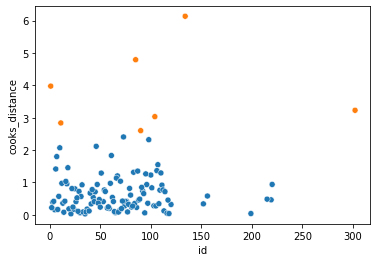

In [326]:
# We use a threshold of 3* the mean of the cluster cook statistics for all subjects.
thresh_cal = cooks_distance.cooks_distance.mean()*3
print(thresh_cal)
# Way to high. Possibly I got this wrong. I'll just choose a threshold by inspection for the moment.
thresh = 0.0005
subs_to_remove = cooks_distance[cooks_distance.cooks_distance>thresh_cal].index.values
print(subs_to_remove)
inds_to_drop = all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),:].index.values
# now remove and re-run analysis:
model_tweedie_adnm_red = smf.gee("ADNM_burden_total ~ C(time) + C(Group, Treatment('CTR'))","id", all_dat_df.drop(labels = inds_to_drop, axis = 0), cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

cooks_distance['above_threshold'] = 0
cooks_distance.loc[cooks_distance.cooks_distance>thresh_cal,'above_threshold']=1
sns.scatterplot(data=cooks_distance, x="id", y="cooks_distance",hue = 'above_threshold',legend = False)

We can have a look at the score for the participants who were marked as outliers above.

In [327]:
all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),['ADNM_burden_total','order','id']].set_index('id').sort_index().reset_index()

,id,ADNM_burden_total,order
0,22.0,65.0,2.0
1,22.0,54.0,1.0
2,22.0,67.0,4.0
3,22.0,67.0,3.0
4,30.0,47.0,1.0
5,30.0,50.0,4.0
6,30.0,55.0,2.0
7,81.0,54.0,3.0
8,81.0,58.0,2.0
9,81.0,71.0,1.0


Subjects who reported the same stressful event in the ADNM at all four assessment time points

In [332]:
all_dat_df.loc[(all_dat_df.order == 1),'same_event'] = 1
all_ids = []
for i, pnum in enumerate(all_dat_df.id.unique()):
    if all_dat_df.loc[all_dat_df['id']==pnum,'same_event'].sum()==4:
        all_ids.append(pnum)
    else:
        continue
all_dat_df['all_same'] = 0
all_dat_df.loc[all_dat_df.id.isin(all_ids),'all_same'] = 1

<AxesSubplot:title={'center':'CTR'}, xlabel='time', ylabel='ADNM_burden_total'>

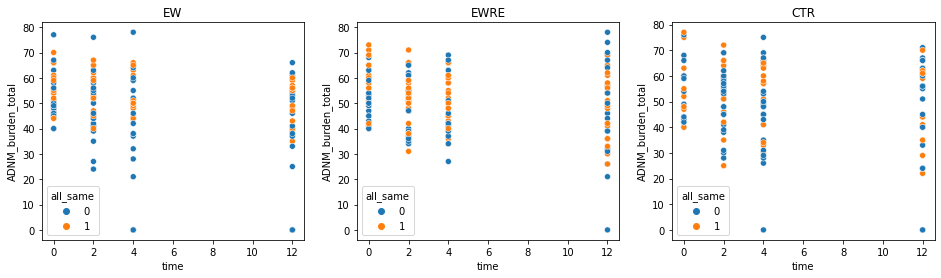

In [333]:
model_tweedie_adnm_re = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR')) * C(all_same,Treatment(0))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie()).fit()
model_tweedie_adnm_re.summary2()
all_dat_df.loc[(all_dat_df.all_same==1)&(all_dat_df.order == 2),'Group'].value_counts()
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)
#sns.boxplot(  y="b", x= "a", data=df,  orient='v' , ax=axes[0])
#sns.boxplot(  y="c", x= "a", data=df,  orient='v' , ax=axes[1])
axes[0].title.set_text('EW')
axes[1].title.set_text('EWRE')
axes[2].title.set_text('CTR')
sns.scatterplot(all_dat_df.time, all_dat_df.loc[all_dat_df.Group == 'EW','ADNM_burden_total'], hue = all_dat_df.all_same,ax = axes[0])
sns.scatterplot(all_dat_df.time, all_dat_df.loc[all_dat_df.Group == 'EWRE','ADNM_burden_total'], hue = all_dat_df.all_same,ax = axes[1])
sns.scatterplot(all_dat_df.time, all_dat_df.loc[all_dat_df.Group == 'CTR','ADNM_burden_total'], hue = all_dat_df.all_same,ax = axes[2])

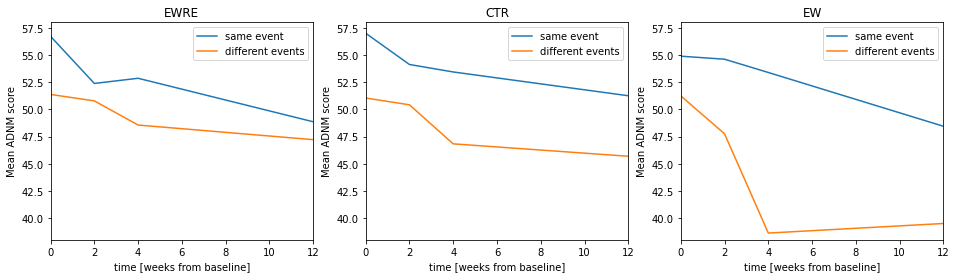

In [358]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text(all_dat_df.Group.unique()[0])
axes[1].title.set_text(all_dat_df.Group.unique()[1])
axes[2].title.set_text(all_dat_df.Group.unique()[2])
x_ax = [0,2,4,12]

all_vals = []
for count,group in enumerate(all_dat_df.Group.unique()):
    same = all_dat_df.loc[(all_dat_df.all_same==1) & (all_dat_df.Group==group),:].groupby('time').ADNM_burden_total.mean()
    not_same = all_dat_df.loc[(all_dat_df.all_same==0) & (all_dat_df.Group==group),:].groupby('time').ADNM_burden_total.mean()
    all_vals.append(same)
    all_vals.append(not_same)



for i in range(0,3):
    axes[i].plot(x_ax, all_vals[i*2])
    axes[i].plot(x_ax, all_vals[i*2+1])
    axes[i].set_xlim([0,12])
    axes[i].set_ylim([38,58])
    axes[i].set_xlabel('time [weeks from baseline]')
    axes[i].set_ylabel('Mean ADNM score')
    axes[i].legend(['same event','different events'])


Moderator analysis - ERQ reapp/sup, RRS scores

In [359]:
# Model mean response structure using a Tweedie distribution, link is log, covariance structure is AR(1)
model_erq_adnm = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))*ERQ_reapp_scaled","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

In [360]:
model_erq_adnm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: GEE
====================================================================================================================
Model:                                 GEE                                AIC:                             nan      
Link Function:                         log                                BIC:                             -375.4291
Dependent Variable:                    ADNM_burden_total                  Log-Likelihood:                  nan      
Date:                                  2021-11-15 12:46                   LL-Null:                         nan      
No. Observations:                      466                                Deviance:                        2340.3   
Df Model:                              23                                 Pearson chi2:                    1.78e+03 
Df Residuals:                          442                                Scale:                           4.0376   
Method:                                IRLS                                                                         
--------------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                                            3.9511   0.0334 118.2628 0.0000  3.8856  4.0166
C(time)[T.2.0]                                                      -0.0102   0.0372  -0.2742 0.7839 -0.0832  0.0627
C(time)[T.4.0]                                                      -0.0421   0.0447  -0.9403 0.3471 -0.1298  0.0456
C(time)[T.12.0]                                                     -0.0847   0.0579  -1.4618 0.1438 -0.1983  0.0289
C(Group, Treatment('CTR'))[T.EW]                                     0.0161   0.0427   0.3776 0.7057 -0.0675  0.0997
C(Group, Treatment('CTR'))[T.EWRE]                                   0.0055   0.0434   0.1275 0.8985 -0.0796  0.0907
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]                      0.0114   0.0507   0.2253 0.8218 -0.0879  0.1107
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]                     -0.0975   0.0708  -1.3768 0.1686 -0.2363  0.0413
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]                    -0.0981   0.0872  -1.1249 0.2606 -0.2690  0.0728
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]                   -0.0096   0.0509  -0.1890 0.8501 -0.1094  0.0901
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]                    0.0157   0.0552   0.2851 0.7756 -0.0925  0.1240
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE]                   0.0041   0.0757   0.0536 0.9573 -0.1443  0.1524
ERQ_reapp_scaled                                                    -0.0618   0.0296  -2.0884 0.0368 -0.1198 -0.0038
C(time)[T.2.0]:ERQ_reapp_scaled                                      0.0692   0.0273   2.5353 0.0112  0.0157  0.1227
C(time)[T.4.0]:ERQ_reapp_scaled                                      0.0737   0.0590   1.2486 0.2118 -0.0420  0.1893
C(time)[T.12.0]:ERQ_reapp_scaled                                     0.0040   0.0496   0.0802 0.9361 -0.0933  0.1012
C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled                    0.0428   0.0382   1.1184 0.2634 -0.0322  0.1177
C(Group, Treatment('CTR'))[T.EWRE]:ERQ_reapp_scaled                  0.0743   0.0440   1.6881 0.0914 -0.0120  0.1607
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled    -0.1293   0.0421  -3.0683 0.0022 -0.2118 -0.0467
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled    -0.1442   0.0737  -1.9565 0.0504 -0.2886  0.0003
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled   -0.0147   0.0821  -0.1789 0.8580 -0.1757  0.1463
C(time)[T.2.0]:C(Group, T

To further explore the possible moderation effect of ERQ, we simulate some data for representative groups (mean +/-1 std) and predict ADNM scores.

We will now simulate ERQ scores in the range +/- 1 std deviation from the mean and predict ADNM-20 scores for these data points using the coefficients from our model.

In [361]:
# get simulated data
predictions = model_erq_adnm.predict(exog = model_df)
model_df['predicted_ADNM'] = predictions


Plot predicted scores for each group and assessment time point.

<AxesSubplot:title={'center':'EW'}, xlabel='ERQ_reapp_scaled', ylabel='predicted_ADNM'>

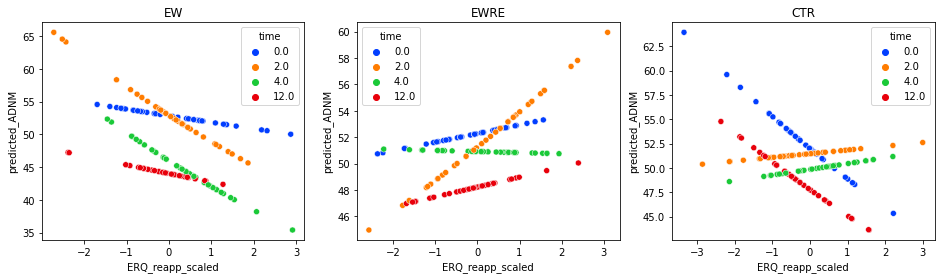

In [364]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text('EW')
axes[1].title.set_text('EWRE')
axes[2].title.set_text('CTR')
sns.scatterplot(model_df.loc[model_df.Group=='CTR','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'CTR','predicted_ADNM'],hue = model_df.time,palette = 'bright',ax = axes[2])
sns.scatterplot(model_df.loc[model_df.Group=='EWRE','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EWRE','predicted_ADNM'],hue = model_df.time,palette = 'bright', ax = axes[1])
sns.scatterplot(model_df.loc[model_df.Group=='EW','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EW','predicted_ADNM'],hue = model_df.time,palette = 'bright', ax = axes[0])


To visualise further, we will create a categorical variable to divide participants into low/med/high ERQ scorers. We will then plot trajectories of ADNM-20 scores over time for each ERQ/writing group.

In [365]:
all_dat_df['ERQ_reapp_cat'] = 1
all_dat_df.loc[all_dat_df.ERQ_reapp>(all_dat_df.ERQ_reapp.mean()+all_dat_df.ERQ_reapp.std()),'ERQ_reapp_cat'] = 2
all_dat_df.loc[all_dat_df.ERQ_reapp<(all_dat_df.ERQ_reapp.mean()-all_dat_df.ERQ_reapp.std()),'ERQ_reapp_cat'] = 0

We will also create categorical variables for ERQ-expressive suppresion and RRS.

In [366]:
all_dat_df['ERQ_sup_cat'] = 1
all_dat_df.loc[all_dat_df.ERQ_sup>(all_dat_df.ERQ_sup.mean()+all_dat_df.ERQ_sup.std()),'ERQ_sup_cat'] = 2
all_dat_df.loc[all_dat_df.ERQ_sup<(all_dat_df.ERQ_sup.mean()-all_dat_df.ERQ_sup.std()),'ERQ_sup_cat'] = 0

In [367]:
all_dat_df['RRS_cat'] = 1
all_dat_df.loc[all_dat_df.RRS_total>(all_dat_df.RRS_total.mean()+all_dat_df.RRS_total.std()),'RRS_cat'] = 2
all_dat_df.loc[all_dat_df.RRS_total<(all_dat_df.RRS_total.mean()-all_dat_df.RRS_total.std()),'RRS_cat'] = 0

In [ ]:
all_dat_df.loc[all_dat_df.ERQ_reapp_cat == 0,:].groupby('time').ADNM_burden_total.mean()

time
0.0     55.166667
2.0     52.555556
4.0     50.823529
12.0    50.000000
Name: ADNM_burden_total, dtype: float64

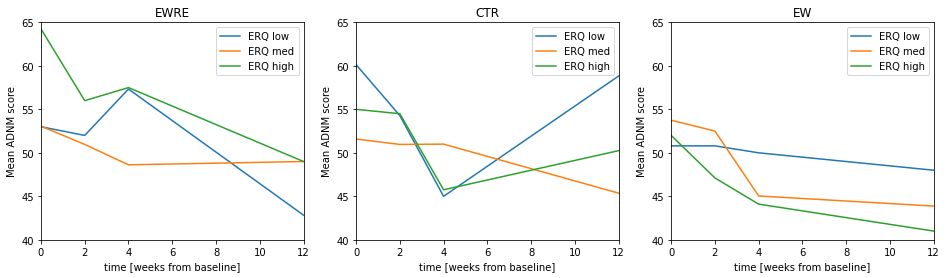

In [371]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text(all_dat_df.Group.unique()[0])
axes[1].title.set_text(all_dat_df.Group.unique()[1])
axes[2].title.set_text(all_dat_df.Group.unique()[2])
x_ax = [0,2,4,12]

all_vals = []
for count,group in enumerate(all_dat_df.Group.unique()):
    erq_lo = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 0) & (all_dat_df.Group == group),:].groupby('time').ADNM_burden_total.mean()
    erq_med = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 1) & (all_dat_df.Group == group),:].groupby('time').ADNM_burden_total.mean()
    erq_hi = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 2) & (all_dat_df.Group == group),:].groupby('time').ADNM_burden_total.mean()
    all_vals.append(erq_lo)
    all_vals.append(erq_med)
    all_vals.append(erq_hi)


for i in range(0,3):
    axes[i].plot(x_ax, all_vals[i*3])
    axes[i].plot(x_ax, all_vals[i*3+1])
    axes[i].plot(x_ax, all_vals[i*3+2])
    axes[i].set_xlim([0,12])
    axes[i].set_ylim([40,65])
    axes[i].set_xlabel('time [weeks from baseline]')
    axes[i].set_ylabel('Mean ADNM score')
    axes[i].legend(['ERQ low','ERQ med','ERQ high'])

DASS subscales

In [410]:
# check whether scores are significantly different at baseline
data = [all_dat_df.loc[all_dat_df.Group == 'EW','dass_depression'].values,all_dat_df.loc[all_dat_df.Group == 'EWRE','dass_depression'].values,all_dat_df.loc[all_dat_df.Group == 'CTR','dass_depression'].values]
print(stats.kruskal(data[0],data[1],data[2]))
print(sp.posthoc_dunn(data, p_adjust = 'bonferroni'))

KruskalResult(statistic=12.17821083802159, pvalue=0.002267436413307883)
          1         2         3
1  1.000000  0.049122  0.002045
2  0.049122  1.000000  0.926168
3  0.002045  0.926168  1.000000


In [ ]:
red_dass_df = all_dat_df.loc[:,['dass_depression','time','id','Group']]
drop_inds = red_dass_df.loc[red_dass_df.dass_depression.isna(),:].index.values
red_dass_df = red_dass_df.drop(labels = drop_inds, axis = 0)

Check how many zeros we have at each assessment time point.

In [372]:
print('IDs with zeros at baseline:', all_dat_df.loc[(all_dat_df.dass_depression==0)&(all_dat_df.order==1),'id'].unique())
print('IDs with zeros at follow-up 1:', all_dat_df.loc[(all_dat_df.dass_depression==0)&(all_dat_df.order==2),'id'].unique())
print('IDs with zeros at follow-up 2:', all_dat_df.loc[(all_dat_df.dass_depression==0)&(all_dat_df.order==3),'id'].unique())
print('IDs with zeros at follow-up 3:', all_dat_df.loc[(all_dat_df.dass_depression==0)&(all_dat_df.order==3),'id'].unique())

IDs with zeros at baseline: [ 6. 85. 23.]
IDs with zeros at follow-up 1: [ 57.  93.  23.   7.  85. 302.]
IDs with zeros at follow-up 2: [ 85.  51.  96. 113.  57.]
IDs with zeros at follow-up 3: [ 85.  51.  96. 113.  57.]


Use Tweedie distribution + log link + Autoregressive 

In [373]:
model_tweedie_dassd= smf.gee("dass_depression ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie()).fit()
model_tweedie_dassd.summary2()

Below we check whether an alternative covariance structure would make sense.

In [374]:
# compare QIC/QICu between different covariance structures.
dassd_qic_df = get_qic_table(all_dat_df, "dass_depression ~ C(time) * C(Group, Treatment('CTR'))","id",sm.families.Tweedie())
print(dassd_qic_df)

  dependency type         QIC        QICu
0    Independence  819.901011  511.355015
1    Exchangeable  821.112033  512.228343
2  Autoregressive  831.003792  510.345161


Model diagnostics (half normal plot, fitted/residuals, time/residuals)

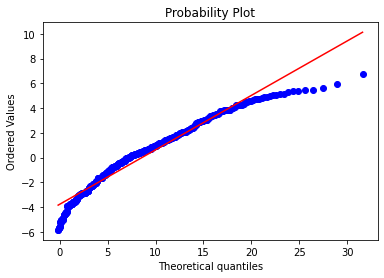

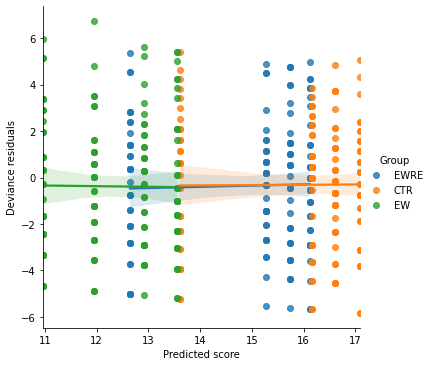

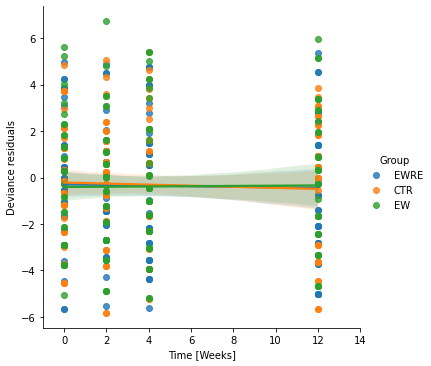

In [375]:
model_checks(all_dat_df,['dass_depression','id','time','Group'],'dass_depression',model_tweedie_dassd)

In [376]:
# Calculate Cook's distance. This attempts to answer the question, "If we exclude participant X from the analysis, how would the coefficient estimates be affected?"
# We'll do the following: Exclude participant x - repeat analysis - calculate change in coefficients (abs) - record - repeat, excluding next participan in line.
# This will take ages for more complex models but I couldn't find an implementation I was happy with.
cooks_dist = []
all_ids = []
for i,pnum in enumerate(all_dat_df.id.unique()):
    # eliminate id from dataframe
    red_df = all_dat_df.drop(labels = all_dat_df.loc[all_dat_df.id == pnum].index.values,axis = 0)
    # fit model
    model_tweedie_dassd_red = smf.gee("dass_depression ~ C(time) * C(Group, Treatment('CTR'))","id", red_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()
    # get coefficients
    diff_full = abs(model_tweedie_dassd.fittedvalues-model_tweedie_dassd_red.fittedvalues)
    cooks_d = np.sum(np.square(diff_full))/(5*np.mean(np.square(model_tweedie_dassd.resid_deviance)))
    cooks_dist.append(cooks_d)
    all_ids.append(pnum)

cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})

0.8632867460079012
[ 11  89  95  96 114 117]


<AxesSubplot:xlabel='id', ylabel='cooks_distance'>

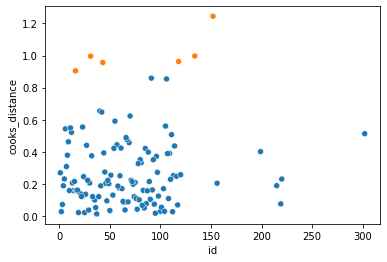

In [377]:
# threshold = 3*mean(cluster cook statistic)
thresh_cal = cooks_distance_df.cooks_distance.mean()*3
print(thresh_cal)
# Way to high. Possibly I got this wrong. I'll just choose a threshold by inspection for the moment.
thresh = 0.0005
subs_to_remove = cooks_distance_df[cooks_distance_df.cooks_distance>thresh_cal].index.values
print(subs_to_remove)
inds_to_drop = all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),:].index.values
# now remove and re-run analysis:
model_tweedie_dassd_red = smf.gee("dass_depression ~ C(time) + C(Group, Treatment('CTR'))","id", all_dat_df.drop(labels = inds_to_drop, axis = 0), cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

cooks_distance_df['above_threshold'] = 0
cooks_distance_df.loc[cooks_distance_df.cooks_distance>thresh_cal,'above_threshold']=1
sns.scatterplot(data=cooks_distance_df, x="id", y="cooks_distance",hue = 'above_threshold',legend = False)

Check scores for subjects flagged as outliers.

In [378]:
all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),['dass_depression','order','id']].set_index('id').sort_index()

,dass_depression,order
id,,
11.0,16,1.0
11.0,24,4.0
11.0,38,3.0
11.0,12,2.0
89.0,12,1.0
89.0,4,4.0
89.0,12,2.0
89.0,16,3.0
95.0,14,1.0


In [380]:
model_erq_dassd= smf.gee("dass_depression ~ C(time) * C(Group, Treatment('CTR'))*ERQ_reapp_scaled","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie()).fit()
model_erq_dassd.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: GEE
===================================================================================================================
Model:                                GEE                                AIC:                              nan     
Link Function:                        log                                BIC:                              594.4002
Dependent Variable:                   dass_depression                    Log-Likelihood:                   nan     
Date:                                 2021-11-15 13:06                   LL-Null:                          nan     
No. Observations:                     469                                Deviance:                         3331.4  
Df Model:                             23                                 Pearson chi2:                     3.17e+03
Df Residuals:                         445                                Scale:                            7.1209  
Method:                               IRLS                                                                         
-------------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                                            2.7229   0.1027 26.5099 0.0000  2.5216  2.9242
C(time)[T.2.0]                                                       0.1071   0.1124  0.9529 0.3406 -0.1132  0.3275
C(time)[T.4.0]                                                      -0.1530   0.1315 -1.1632 0.2448 -0.4107  0.1048
C(time)[T.12.0]                                                      0.0163   0.1248  0.1307 0.8960 -0.2283  0.2609
C(Group, Treatment('CTR'))[T.EW]                                    -0.1583   0.1575 -1.0055 0.3147 -0.4670  0.1503
C(Group, Treatment('CTR'))[T.EWRE]                                   0.0360   0.1487  0.2423 0.8085 -0.2555  0.3276
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]                     -0.1808   0.1608 -1.1243 0.2609 -0.4959  0.1344
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]                      0.2023   0.1827  1.1073 0.2681 -0.1558  0.5604
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]                    -0.1688   0.2109 -0.8003 0.4236 -0.5823  0.2446
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]                   -0.1394   0.1438 -0.9693 0.3324 -0.4214  0.1425
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]                    0.1563   0.1707  0.9156 0.3599 -0.1782  0.4908
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE]                  -0.2321   0.1808 -1.2835 0.1993 -0.5864  0.1223
ERQ_reapp_scaled                                                    -0.2373   0.0903 -2.6282 0.0086 -0.4143 -0.0603
C(time)[T.2.0]:ERQ_reapp_scaled                                      0.1625   0.0855  1.9010 0.0573 -0.0050  0.3301
C(time)[T.4.0]:ERQ_reapp_scaled                                      0.1076   0.1225  0.8779 0.3800 -0.1326  0.3477
C(time)[T.12.0]:ERQ_reapp_scaled                                     0.0999   0.1011  0.9886 0.3228 -0.0982  0.2980
C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled                   -0.0055   0.1390 -0.0393 0.9687 -0.2780  0.2670
C(Group, Treatment('CTR'))[T.EWRE]:ERQ_reapp_scaled                  0.3153   0.1511  2.0869 0.0369  0.0192  0.6115
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled    -0.0675   0.1131 -0.5964 0.5509 -0.2892  0.1543
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled    -0.1133   0.1578 -0.7177 0.4729 -0.4225  0.1960
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled   -0.0155   0.1607 -0.0966 0.9231 -0.3306  0.2995
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]:ERQ_reapp

<AxesSubplot:title={'center':'EW'}, xlabel='ERQ_reapp_scaled', ylabel='predicted_dassd'>

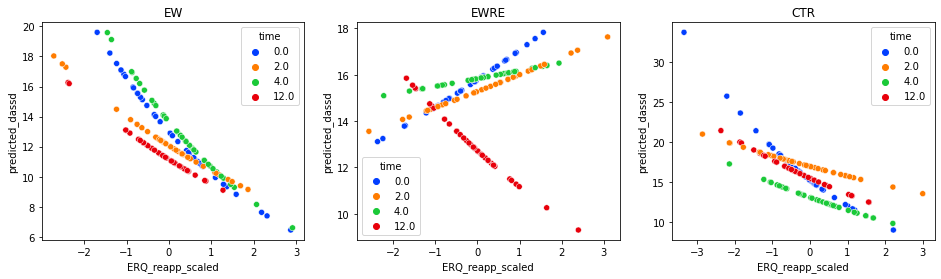

In [381]:
predictions = model_erq_dassd.predict(exog = model_df)
model_df['predicted_dassd'] = predictions
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text('EW')
axes[1].title.set_text('EWRE')
axes[2].title.set_text('CTR')
sns.scatterplot(model_df.loc[model_df.Group=='CTR','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'CTR','predicted_dassd'],hue = model_df.time,palette = 'bright',ax = axes[2])
sns.scatterplot(model_df.loc[model_df.Group=='EWRE','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EWRE','predicted_dassd'],hue = model_df.time,palette = 'bright', ax = axes[1])
sns.scatterplot(model_df.loc[model_df.Group=='EW','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EW','predicted_dassd'],hue = model_df.time,palette = 'bright', ax = axes[0])

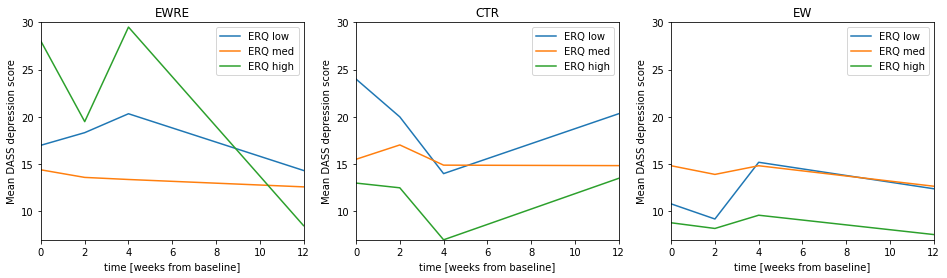

In [384]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text(all_dat_df.Group.unique()[0])
axes[1].title.set_text(all_dat_df.Group.unique()[1])
axes[2].title.set_text(all_dat_df.Group.unique()[2])
x_ax = [0,2,4,12]

all_vals = []
for count,group in enumerate(all_dat_df.Group.unique()):
    erq_lo = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 0) & (all_dat_df.Group == group),:].groupby('time').dass_depression.mean()
    erq_med = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 1) & (all_dat_df.Group == group),:].groupby('time').dass_depression.mean()
    erq_hi = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 2) & (all_dat_df.Group == group),:].groupby('time').dass_depression.mean()
    all_vals.append(erq_lo)
    all_vals.append(erq_med)
    all_vals.append(erq_hi)


for i in range(0,3):
    axes[i].plot(x_ax, all_vals[i*3])
    axes[i].plot(x_ax, all_vals[i*3+1])
    axes[i].plot(x_ax, all_vals[i*3+2])
    axes[i].set_xlim([0,12])
    axes[i].set_ylim([7,30])
    axes[i].set_xlabel('time [weeks from baseline]')
    axes[i].set_ylabel('Mean DASS depression score')
    axes[i].legend(['ERQ low','ERQ med','ERQ high'])


DASS anxiety

In [411]:
# check whether scores are significantly different at baseline
data = [all_dat_df.loc[all_dat_df.Group == 'EW','dass_anxiety'].values,all_dat_df.loc[all_dat_df.Group == 'EWRE','dass_anxiety'].values,all_dat_df.loc[all_dat_df.Group == 'CTR','dass_anxiety'].values]
print(stats.kruskal(data[0],data[1],data[2]))
print(sp.posthoc_dunn(data, p_adjust = 'bonferroni'))

KruskalResult(statistic=12.758594582950717, pvalue=0.001696314552598476)
          1         2         3
1  1.000000  0.007739  0.004522
2  0.007739  1.000000  1.000000
3  0.004522  1.000000  1.000000


In [385]:
model_tweedie_dassa = smf.gee("dass_anxiety~ C(time)* C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie()).fit()
model_tweedie_dassa.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: GEE
=================================================================================================
Model:                          GEE                          AIC:                        nan     
Link Function:                  log                          BIC:                        371.6976
Dependent Variable:             dass_anxiety                 Log-Likelihood:             nan     
Date:                           2021-11-15 13:11             LL-Null:                    nan     
No. Observations:               469                          Deviance:                   3182.5  
Df Model:                       11                           Pearson chi2:               3.47e+03
Df Residuals:                   457                          Scale:                      7.5885  
Method:                         IRLS                                                             
-------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------
Intercept                                           2.1479   0.1574 13.6426 0.0000  1.8394 2.4565
C(time)[T.2.0]                                      0.0319   0.1180  0.2701 0.7871 -0.1994 0.2632
C(time)[T.4.0]                                     -0.0125   0.1589 -0.0784 0.9375 -0.3240 0.2990
C(time)[T.12.0]                                     0.1027   0.1183  0.8687 0.3850 -0.1290 0.3345
C(Group, Treatment('CTR'))[T.EW]                   -0.3486   0.2487 -1.4020 0.1609 -0.8360 0.1387
C(Group, Treatment('CTR'))[T.EWRE]                 -0.0572   0.1930 -0.2965 0.7669 -0.4354 0.3210
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]     0.0950   0.1665  0.5706 0.5682 -0.2313 0.4213
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]     0.1221   0.2465  0.4954 0.6203 -0.3611 0.6053
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]    0.1491   0.1917  0.7777 0.4367 -0.2266 0.5248
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]   0.0724   0.1616  0.4482 0.6540 -0.2443 0.3891
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]   0.1252   0.2206  0.5676 0.5703 -0.3072 0.5576
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE] -0.2479   0.1922 -1.2899 0.1971 -0.6246 0.1288
=================================================================================================

"""

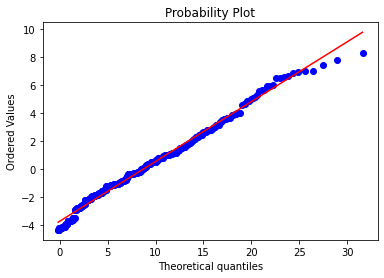

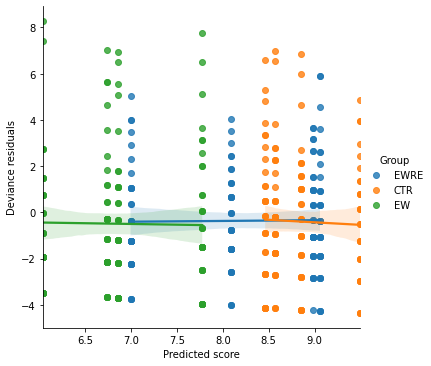

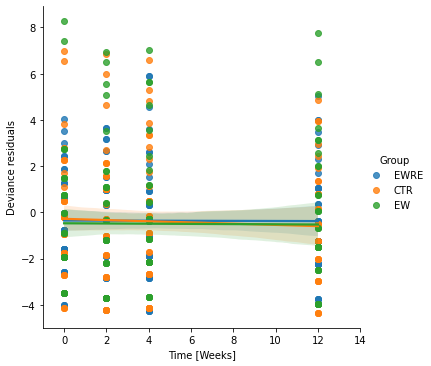

In [397]:
model_checks(all_dat_df,['dass_anxiety','id','time','Group'],'dass_anxiety',model_tweedie_dassa)

In [394]:
# Calculate Cook's distance. This attempts to answer the question, "If we exclude participant X from the analysis, how would the coefficient estimates be affected?"
# We'll do the following: Exclude participant x - repeat analysis - calculate change in coefficients (abs) - record - repeat, excluding next participan in line.
# This will take ages for more complex models but I couldn't find an implementation I was happy with.
cooks_dist = []
all_ids = []
for i,pnum in enumerate(all_dat_df.id.unique()):
    # eliminate id from dataframe
    red_df = all_dat_df.drop(labels = all_dat_df.loc[all_dat_df.id == pnum].index.values,axis = 0)
    # fit model
    model_tweedie_dassa_red = smf.gee("dass_anxiety ~ C(time) * C(Group, Treatment('CTR'))","id", red_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Tweedie(),missing = 'drop').fit()
    # get coefficients
    diff_full = abs(model_tweedie_dassa.fittedvalues-model_tweedie_dassa_red.fittedvalues)
    cooks_d = np.sum(np.square(diff_full))/(5*np.mean(np.square(model_tweedie_dassa.resid_deviance)))
    cooks_dist.append(cooks_d)
    all_ids.append(pnum)

cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})

3.998238065858546
[]


<AxesSubplot:xlabel='id', ylabel='cooks_distance'>

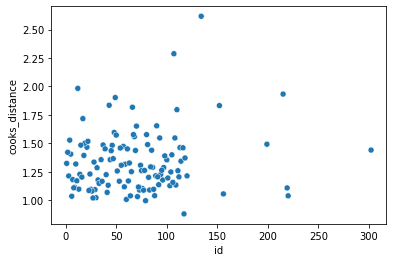

In [395]:
# to calculate the threshold, we use the formula 3p/(n*T), where p = number of predictors, n = number of clusters, T = number of measurements for each cluster
#thresh_cal = (3*2)/(119*5)
thresh_cal = cooks_distance_df.cooks_distance.mean()*3
print(thresh_cal)
# Way to high. Possibly I got this wrong. I'll just choose a threshold by inspection for the moment.
thresh = 0.0005
subs_to_remove = cooks_distance_df[cooks_distance_df.cooks_distance>thresh_cal].index.values
print(subs_to_remove)
inds_to_drop = all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),:].index.values
# now remove and re-run analysis:
model_tweedie_dassa_red = smf.gee("dass_anxiety ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df.drop(labels = inds_to_drop, axis = 0), cov_struct = sm.cov_struct.Independence(), family = sm.families.Tweedie(),missing = 'drop').fit()

cooks_distance_df['above_threshold'] = 0
cooks_distance_df.loc[cooks_distance_df.cooks_distance>thresh_cal,'above_threshold']=1
sns.scatterplot(data=cooks_distance_df, x="id", y="cooks_distance",hue = 'above_threshold',legend = False)

Exploratory analysis - add moderators

In [388]:
model_erq_dassa = smf.gee("dass_anxiety~ C(time)* C(Group, Treatment('CTR'))*ERQ_reapp_scaled","id", all_dat_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Tweedie()).fit()
model_erq_dassa.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: GEE
===================================================================================================================
Model:                                GEE                                AIC:                              nan     
Link Function:                        log                                BIC:                              367.5305
Dependent Variable:                   dass_anxiety                       Log-Likelihood:                   nan     
Date:                                 2021-11-15 13:14                   LL-Null:                          nan     
No. Observations:                     469                                Deviance:                         3104.5  
Df Model:                             23                                 Pearson chi2:                     3.30e+03
Df Residuals:                         445                                Scale:                            7.4235  
Method:                               IRLS                                                                         
-------------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                                            2.1391   0.1389 15.4023 0.0000  1.8669  2.4113
C(time)[T.2.0]                                                       0.0500   0.1021  0.4895 0.6245 -0.1501  0.2501
C(time)[T.4.0]                                                       0.0228   0.1237  0.1846 0.8536 -0.2196  0.2653
C(time)[T.12.0]                                                      0.0131   0.1215  0.1077 0.9142 -0.2250  0.2512
C(Group, Treatment('CTR'))[T.EW]                                    -0.2955   0.2393 -1.2351 0.2168 -0.7645  0.1734
C(Group, Treatment('CTR'))[T.EWRE]                                  -0.1015   0.1798 -0.5643 0.5725 -0.4538  0.2509
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]                      0.0412   0.1515  0.2718 0.7857 -0.2557  0.3381
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]                      0.0765   0.2117  0.3612 0.7180 -0.3385  0.4914
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]                     0.2139   0.1945  1.0996 0.2715 -0.1673  0.5951
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]                    0.0791   0.1463  0.5405 0.5889 -0.2076  0.3658
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]                    0.1384   0.1957  0.7072 0.4795 -0.2452  0.5219
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE]                  -0.1257   0.1954 -0.6433 0.5200 -0.5087  0.2573
ERQ_reapp_scaled                                                    -0.1916   0.0895 -2.1398 0.0324 -0.3671 -0.0161
C(time)[T.2.0]:ERQ_reapp_scaled                                      0.1390   0.0815  1.7047 0.0882 -0.0208  0.2987
C(time)[T.4.0]:ERQ_reapp_scaled                                      0.1737   0.0885  1.9623 0.0497  0.0002  0.3472
C(time)[T.12.0]:ERQ_reapp_scaled                                     0.0468   0.0921  0.5080 0.6114 -0.1338  0.2274
C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled                    0.0210   0.1684  0.1244 0.9010 -0.3092  0.3511
C(Group, Treatment('CTR'))[T.EWRE]:ERQ_reapp_scaled                  0.2375   0.1807  1.3147 0.1886 -0.1166  0.5916
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled    -0.0288   0.1508 -0.1910 0.8485 -0.3244  0.2668
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled    -0.2732   0.1391 -1.9638 0.0496 -0.5458 -0.0005
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled   -0.0374   0.1328 -0.2813 0.7785 -0.2976  0.2229
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]:ERQ_reapp

<AxesSubplot:title={'center':'EW'}, xlabel='ERQ_reapp_scaled', ylabel='predicted_dassa'>

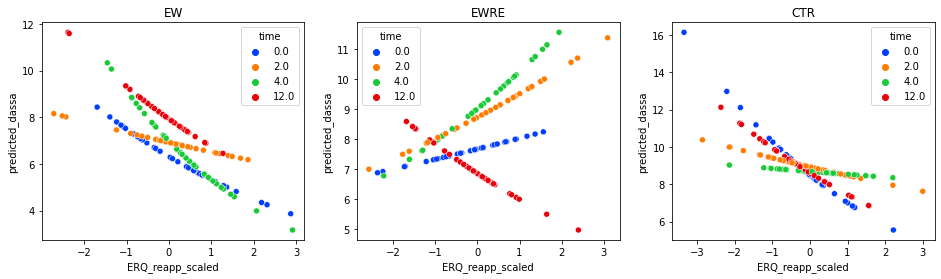

In [390]:
predictions = model_erq_dassa.predict(exog = model_df)
model_df['predicted_dassa'] = predictions
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text('EW')
axes[1].title.set_text('EWRE')
axes[2].title.set_text('CTR')
sns.scatterplot(model_df.loc[model_df.Group=='CTR','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'CTR','predicted_dassa'],hue = model_df.time,palette = 'bright',ax = axes[2])
sns.scatterplot(model_df.loc[model_df.Group=='EWRE','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EWRE','predicted_dassa'],hue = model_df.time,palette = 'bright', ax = axes[1])
sns.scatterplot(model_df.loc[model_df.Group=='EW','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EW','predicted_dassa'],hue = model_df.time,palette = 'bright', ax = axes[0])

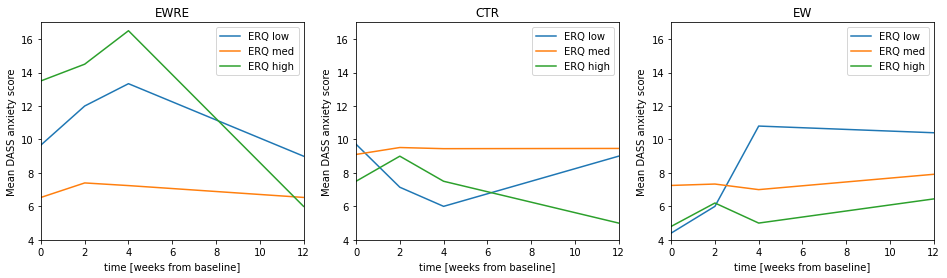

In [393]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text(all_dat_df.Group.unique()[0])
axes[1].title.set_text(all_dat_df.Group.unique()[1])
axes[2].title.set_text(all_dat_df.Group.unique()[2])
x_ax = [0,2,4,12]

all_vals = []
for count,group in enumerate(all_dat_df.Group.unique()):
    erq_lo = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 0) & (all_dat_df.Group == group),:].groupby('time').dass_anxiety.mean()
    erq_med = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 1) & (all_dat_df.Group == group),:].groupby('time').dass_anxiety.mean()
    erq_hi = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 2) & (all_dat_df.Group == group),:].groupby('time').dass_anxiety.mean()
    all_vals.append(erq_lo)
    all_vals.append(erq_med)
    all_vals.append(erq_hi)


for i in range(0,3):
    axes[i].plot(x_ax, all_vals[i*3])
    axes[i].plot(x_ax, all_vals[i*3+1])
    axes[i].plot(x_ax, all_vals[i*3+2])
    axes[i].set_xlim([0,12])
    axes[i].set_ylim([4,17])
    axes[i].set_xlabel('time [weeks from baseline]')
    axes[i].set_ylabel('Mean DASS anxiety score')
    axes[i].legend(['ERQ low','ERQ med','ERQ high'])



DASS stress

In [ ]:
all_dat_df.groupby('order').dass_stress.describe()

,count,mean,std,min,25%,50%,75%,max
order,,,,,,,,
1.0,119.0,15.579832,8.763847,0.0,10.0,14.0,20.0,40.0
2.0,119.0,15.983193,9.129931,0.0,10.0,14.0,23.0,40.0
3.0,117.0,15.196581,9.584685,0.0,8.0,14.0,22.0,40.0
4.0,114.0,14.105263,8.759691,0.0,8.0,14.0,20.0,42.0


In [412]:
# check whether scores are significantly different at baseline
data = [all_dat_df.loc[all_dat_df.Group == 'EW','dass_stress'].values,all_dat_df.loc[all_dat_df.Group == 'EWRE','dass_stress'].values,all_dat_df.loc[all_dat_df.Group == 'CTR','dass_stress'].values]
print(stats.kruskal(data[0],data[1],data[2]))
print(sp.posthoc_dunn(data, p_adjust = 'bonferroni'))

KruskalResult(statistic=3.884047116149659, pvalue=0.14341345050994256)
          1         2        3
1  1.000000  0.243383  0.28443
2  0.243383  1.000000  1.00000
3  0.284430  1.000000  1.00000


In [409]:
# check whether scores are significantly different at baselin
print(stats.kruskal(all_dat_df.loc[all_dat_df.Group == 'EW','ERQ_reapp'],all_dat_df.loc[all_dat_df.Group == 'EWRE','ERQ_reapp'],all_dat_df.loc[all_dat_df.Group == 'CTR','ERQ_reapp']))
data = [all_dat_df.loc[all_dat_df.Group == 'EW','ERQ_reapp'].values,all_dat_df.loc[all_dat_df.Group == 'EWRE','ERQ_reapp'].values,all_dat_df.loc[all_dat_df.Group == 'CTR','ERQ_reapp'].values]
print(sp.posthoc_dunn(data, p_adjust = 'bonferroni'))

KruskalResult(statistic=9.006741291865369, pvalue=0.011071615079467141)
          1         2         3
1  1.000000  1.000000  0.013684
2  1.000000  1.000000  0.068815
3  0.013684  0.068815  1.000000


In [398]:
model_tweedie_dasss = smf.gee("dass_stress~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie()).fit()
model_tweedie_dasss.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: GEE
==================================================================================================
Model:                          GEE                          AIC:                        nan      
Link Function:                  log                          BIC:                        -125.5037
Dependent Variable:             dass_stress                  Log-Likelihood:             nan      
Date:                           2021-11-15 13:24             LL-Null:                    nan      
No. Observations:               469                          Deviance:                   2685.3   
Df Model:                       11                           Pearson chi2:               2.48e+03 
Df Residuals:                   457                          Scale:                      5.4177   
Method:                         IRLS                                                              
--------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------------------
Intercept                                           2.7171   0.1039 26.1441 0.0000  2.5134  2.9208
C(time)[T.2.0]                                      0.0794   0.0992  0.8006 0.4233 -0.1150  0.2739
C(time)[T.4.0]                                     -0.0114   0.1004 -0.1131 0.9099 -0.2081  0.1854
C(time)[T.12.0]                                     0.1704   0.1027  1.6599 0.0969 -0.0308  0.3717
C(Group, Treatment('CTR'))[T.EW]                   -0.0951   0.1401 -0.6788 0.4972 -0.3698  0.1795
C(Group, Treatment('CTR'))[T.EWRE]                  0.1226   0.1253  0.9780 0.3281 -0.1231  0.3683
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]     0.0148   0.1358  0.1090 0.9132 -0.2514  0.2810
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]     0.0663   0.1430  0.4639 0.6427 -0.2139  0.3466
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]   -0.2544   0.1487 -1.7115 0.0870 -0.5458  0.0369
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]  -0.0703   0.1268 -0.5546 0.5791 -0.3188  0.1782
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]  -0.0671   0.1272 -0.5275 0.5979 -0.3163  0.1822
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE] -0.4272   0.1411 -3.0273 0.0025 -0.7038 -0.1506
==================================================================================================

"""

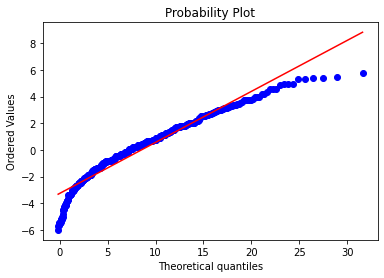

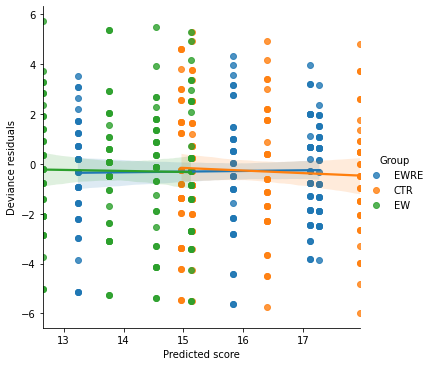

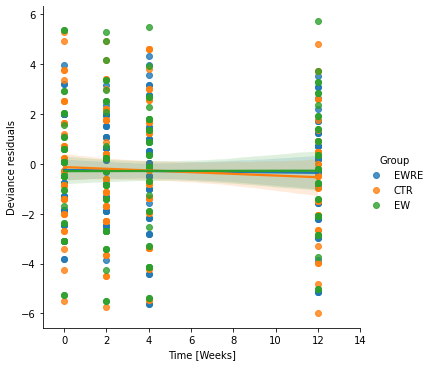

In [414]:
model_checks(all_dat_df,['dass_stress','id','time','Group'],'dass_stress',model_tweedie_dasss)

In [406]:
# Calculate Cook's distance. This attempts to answer the question, "If we exclude participant X from the analysis, how would the coefficient estimates be affected?"
# We'll do the following: Exclude participant x - repeat analysis - calculate change in coefficients (abs) - record - repeat, excluding next participan in line.
# This will take ages for more complex models but I couldn't find an implementation I was happy with.
cooks_dist = []
all_ids = []
for i,pnum in enumerate(all_dat_df.id.unique()):
    # eliminate id from dataframe
    red_df = all_dat_df.drop(labels = all_dat_df.loc[all_dat_df.id == pnum].index.values,axis = 0)
    # fit model
    model_tweedie_dasss_red = smf.gee("dass_stress ~ C(time) * C(Group, Treatment('CTR'))","id", red_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()
    # get coefficients
    diff_full = abs(model_tweedie_dasss.fittedvalues-model_tweedie_dasss_red.fittedvalues)
    cooks_d = np.sum(np.square(diff_full))/(5*np.mean(np.square(model_tweedie_dasss.resid_deviance)))
    cooks_dist.append(cooks_d)
    all_ids.append(pnum)

cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})

0.8957591895283655
[44 57 64 87 89]


<AxesSubplot:xlabel='id', ylabel='cooks_distance'>

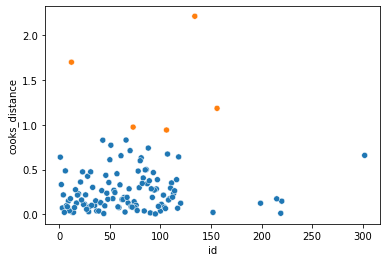

In [407]:
# threshold = 3*mean
thresh_cal = cooks_distance_df.cooks_distance.mean()*3
print(thresh_cal)
# Way to high. Possibly I got this wrong. I'll just choose a threshold by inspection for the moment.
thresh = 0.0005
subs_to_remove = cooks_distance_df[cooks_distance_df.cooks_distance>thresh_cal].index.values
print(subs_to_remove)
inds_to_drop = all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),:].index.values
# now remove and re-run analysis:
model_tweedie_dasss_red = smf.gee("dass_stress ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df.drop(labels = inds_to_drop, axis = 0), cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

cooks_distance_df['above_threshold'] = 0
cooks_distance_df.loc[cooks_distance_df.cooks_distance>thresh_cal,'above_threshold']=1
sns.scatterplot(data=cooks_distance_df, x="id", y="cooks_distance",hue = 'above_threshold',legend = False)

In [400]:
model_erq_dasss = smf.gee("dass_stress~ C(time) * C(Group, Treatment('CTR'))*ERQ_reapp_scaled","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie()).fit()
model_erq_dasss.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: GEE
===================================================================================================================
Model:                                 GEE                               AIC:                             nan      
Link Function:                         log                               BIC:                             -122.9468
Dependent Variable:                    dass_stress                       Log-Likelihood:                  nan      
Date:                                  2021-11-15 13:25                  LL-Null:                         nan      
No. Observations:                      469                               Deviance:                        2614.1   
Df Model:                              23                                Pearson chi2:                    2.40e+03 
Df Residuals:                          445                               Scale:                           5.3943   
Method:                                IRLS                                                                        
-------------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                                            2.6446   0.1050 25.1894 0.0000  2.4388  2.8504
C(time)[T.2.0]                                                       0.1579   0.1009  1.5642 0.1178 -0.0399  0.3556
C(time)[T.4.0]                                                       0.0076   0.1138  0.0672 0.9464 -0.2154  0.2307
C(time)[T.12.0]                                                      0.2031   0.1202  1.6898 0.0911 -0.0325  0.4386
C(Group, Treatment('CTR'))[T.EW]                                    -0.0148   0.1396 -0.1058 0.9157 -0.2884  0.2588
C(Group, Treatment('CTR'))[T.EWRE]                                   0.1732   0.1270  1.3639 0.1726 -0.0757  0.4220
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]                     -0.0670   0.1381 -0.4855 0.6273 -0.3377  0.2036
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]                      0.0470   0.1536  0.3059 0.7597 -0.2540  0.3479
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]                    -0.2858   0.1602 -1.7840 0.0744 -0.5998  0.0282
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]                   -0.1267   0.1277 -0.9923 0.3210 -0.3769  0.1235
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]                   -0.0654   0.1384 -0.4724 0.6366 -0.3366  0.2059
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE]                  -0.4476   0.1543 -2.9012 0.0037 -0.7499 -0.1452
ERQ_reapp_scaled                                                    -0.1862   0.1102 -1.6890 0.0912 -0.4022  0.0299
C(time)[T.2.0]:ERQ_reapp_scaled                                      0.1842   0.0831  2.2179 0.0266  0.0214  0.3470
C(time)[T.4.0]:ERQ_reapp_scaled                                      0.0028   0.1027  0.0276 0.9780 -0.1984  0.2041
C(time)[T.12.0]:ERQ_reapp_scaled                                     0.0699   0.1088  0.6427 0.5204 -0.1433  0.2831
C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled                    0.0658   0.1330  0.4949 0.6207 -0.1949  0.3265
C(Group, Treatment('CTR'))[T.EWRE]:ERQ_reapp_scaled                  0.1520   0.1349  1.1271 0.2597 -0.1124  0.4165
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled    -0.1544   0.1046 -1.4759 0.1400 -0.3594  0.0506
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled     0.0722   0.1330  0.5431 0.5871 -0.1884  0.3328
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled   -0.0400   0.1433 -0.2790 0.7803 -0.3208  0.2409
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]:ERQ_reapp

<AxesSubplot:title={'center':'EW'}, xlabel='ERQ_reapp_scaled', ylabel='predicted_dasss'>

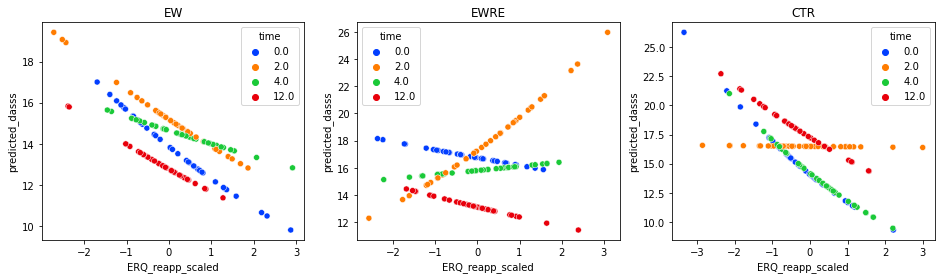

In [401]:
predictions = model_erq_dasss.predict(exog = model_df)
model_df['predicted_dasss'] = predictions
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text('EW')
axes[1].title.set_text('EWRE')
axes[2].title.set_text('CTR')

sns.scatterplot(model_df.loc[model_df.Group=='CTR','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'CTR','predicted_dasss'],hue = model_df.time,palette = 'bright',ax = axes[2])
sns.scatterplot(model_df.loc[model_df.Group=='EWRE','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EWRE','predicted_dasss'],hue = model_df.time,palette = 'bright', ax = axes[1])
sns.scatterplot(model_df.loc[model_df.Group=='EW','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EW','predicted_dasss'],hue = model_df.time,palette = 'bright', ax = axes[0])

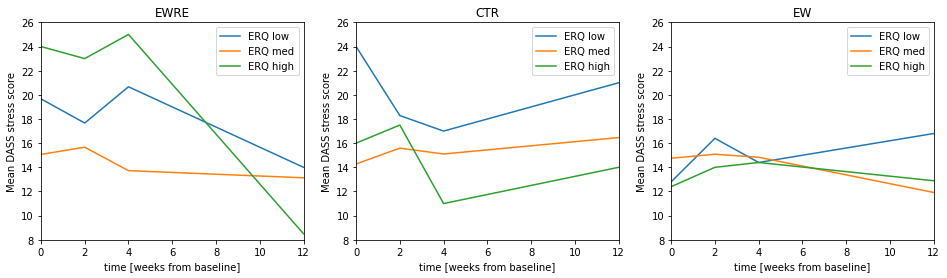

In [405]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text(all_dat_df.Group.unique()[0])
axes[1].title.set_text(all_dat_df.Group.unique()[1])
axes[2].title.set_text(all_dat_df.Group.unique()[2])
x_ax = [0,2,4,12]

all_vals = []
for count,group in enumerate(all_dat_df.Group.unique()):
    erq_lo = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 0) & (all_dat_df.Group == group),:].groupby('time').dass_stress.mean()
    erq_med = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 1) & (all_dat_df.Group == group),:].groupby('time').dass_stress.mean()
    erq_hi = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 2) & (all_dat_df.Group == group),:].groupby('time').dass_stress.mean()
    all_vals.append(erq_lo)
    all_vals.append(erq_med)
    all_vals.append(erq_hi)


for i in range(0,3):
    axes[i].plot(x_ax, all_vals[i*3])
    axes[i].plot(x_ax, all_vals[i*3+1])
    axes[i].plot(x_ax, all_vals[i*3+2])
    axes[i].set_xlim([0,12])
    axes[i].set_ylim([8,26])
    axes[i].set_xlabel('time [weeks from baseline]')
    axes[i].set_ylabel('Mean DASS stress score')
    axes[i].legend(['ERQ low','ERQ med','ERQ high'])

